In [31]:
import osmnx as ox
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from sklearn.metrics import jaccard_score


In [64]:
def plot1(G,ids,labels,name):

    nc = ["w" for node in G.nodes()]
    ns = [0 for node in G.nodes()]
    nodes_G = list(G.nodes)
    #cols = ["C0", "C1", 'C2']
    ids=np.array(ids)
    ids=ids[labels>=0]
    labels=labels[labels>=0]
    la, co = np.unique(labels, return_counts=True)
    la_l=la[np.argsort(-co)]
    nodes_G=np.array(nodes_G)

    for c in range(0, len(ids)):
        # print(c)
        nc[np.where(nodes_G == ids[c])[0][0]] = 'C'+str(int(la_l[int(labels[c])]%7))
        ns[np.where(nodes_G == ids[c])[0][0]] = 2

    ox.plot_graph(G, edge_linewidth=0.1, node_size=ns, node_color=nc, bgcolor='w',save=True, filepath=name, dpi=600)

    return(nc,ns)




In [68]:
place='Manhattan, New York City, New York, USA'
G = ox.graph_from_place(place)


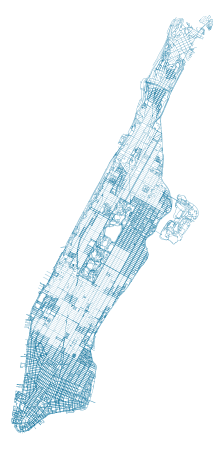

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [70]:
ox.plot.plot_graph(G,edge_linewidth=0.1,edge_color='C0',node_size=0,bgcolor='w',save=True, filepath='Manhattan.png')

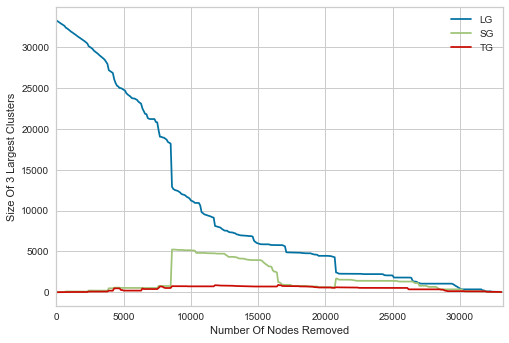

In [2]:

X_G = [[G.nodes[node]['y'], G.nodes[node]['x']] for node in G.nodes]
ids_G = [list(G.nodes())[i] for i in range(0, len(list(G.nodes())))]

nodes_G = list(G.nodes)
LG = np.zeros(int(len(nodes_G) / 100))
SG = np.zeros(int(len(nodes_G) / 100))
TG = np.zeros(int(len(nodes_G) / 100))

for i in range(0, int(len(nodes_G) / 100)):
    G2 = G.copy()
    G2.remove_nodes_from(nodes_G[0:100 * i])
    conn = nx.weakly_connected_components(G2)
    conn_list = list(conn)
    LG[i] = len(sorted(conn_list, key=len, reverse=True)[0])
    if (len(conn_list) > 2):
        SG[i] = len(sorted(conn_list, key=len, reverse=True)[1])
        TG[i] = len(sorted(conn_list, key=len, reverse=True)[2])

plt.plot(np.linspace(0,(len(LG)-1)*100,332),LG,label='LG')
plt.plot(np.linspace(0,(len(LG)-1)*100,332),SG,label='SG')
plt.plot(np.linspace(0,(len(LG)-1)*100,332),TG,label='TG')
plt.legend()
plt.ylabel('Size Of 3 Largest Clusters')
plt.xlabel('Number Of Nodes Removed')
plt.xlim(0,len(LG)*100)
plt.savefig('G.png',dpi=600)
nc_g,ns_g=plot1(G,ids_G3,labels,'ground_truth.png')


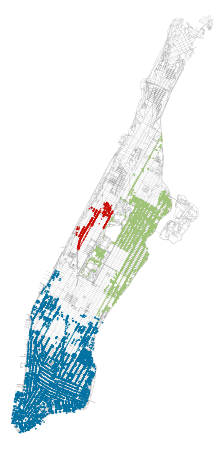

In [105]:

w = np.where(SG == np.max(SG))[0][0]

G2 = G.copy()
G2.remove_nodes_from(nodes_G[0:int(w*100)])
conn = nx.weakly_connected_components(G2)
conn_list = list(conn)
conn_list = sorted(conn_list, key=len, reverse=True)
G3 = G2.copy()
for i in range(0, len(conn_list) - 3):
    G3.remove_nodes_from(conn_list[i + 3])

X_G3 = [[G3.nodes[node]['y'], G3.nodes[node]['x']] for node in G3.nodes]
ids_G3 = [list(G3.nodes())[i] for i in range(0, len(list(G3.nodes())))]


labels=np.zeros(len(ids_G3))

for i in range(0,len(ids_G3)):
    if(ids_G3[i] in conn_list[0]):
        labels[i]=0

    if(ids_G3[i] in conn_list[1]):
        labels[i]=1

    if(ids_G3[i] in conn_list[2]):
        labels[i]=2

nc_g,ns_g=plot1(G,ids_G3,labels,'ground_truth.png')


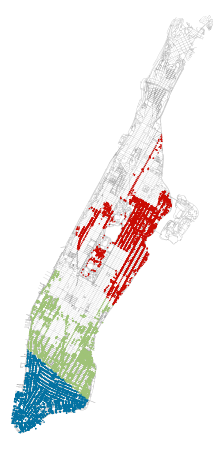

In [15]:

#kmeans n_clusters=3
model = KMeans(n_clusters=3, random_state=0).fit(X_G3)
k3_labels = model.labels_
#kmeans_labels = np.unique(model_labels[model_labels >= 0])

nc_k3,ns_k3=plot1(G, ids_G3, k3_labels,'kmeans_3.png')



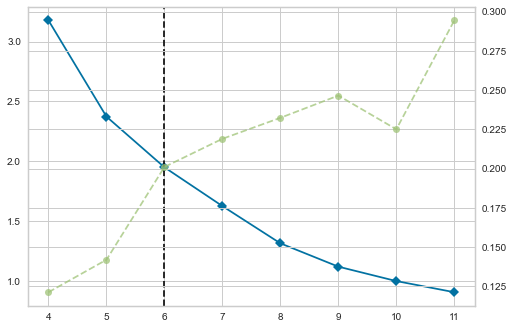

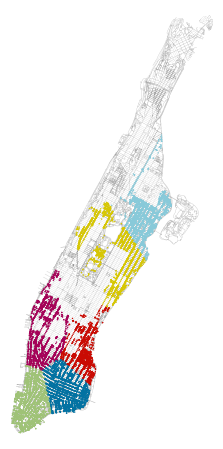

In [16]:
#kmeans elbow method

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 12))

visualizer.fit(np.array(X_G3))  # Fit the data to the visualizer
model = KMeans(n_clusters=visualizer.elbow_value_, random_state=0).fit(X_G3)
ke_labels = model.labels_
#kmeans_labels = np.unique(model_labels[model_labels >= 0])

nc_ke,ns_ke=plot1(G, ids_G3, ke_labels,'kmeans_elbow.png')


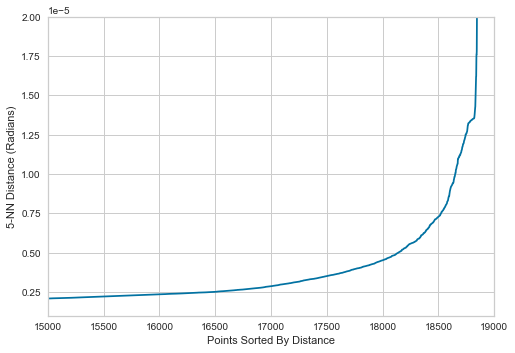

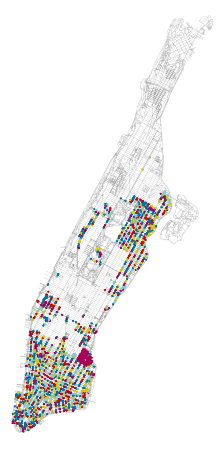

In [71]:

#dbscan epsilon elbow method

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(np.radians(X_G3))
distances, indices = nbrs.kneighbors(np.radians(X_G3))
distances = distances[:, 1]
distances = np.sort(distances, axis=0)
fig=plt.figure()
plt.plot(distances)
plt.xlim(15000, 19000)
plt.ylim(.000001, .00002)


plt.ylabel('5-NN Distance (Radians)')
plt.xlabel('Points Sorted By Distance')
plt.savefig('dbscan_elbow',dpi=600)



model = DBSCAN(eps=0.000005, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(X_G3))

dbe_labels = model.labels_
#db_labels = np.unique(model_labels[model_labels >= 0])
nc_dbe,ns_dbe=plot1(G, ids_G3, dbe_labels,'dbscan_elbow_G.png')


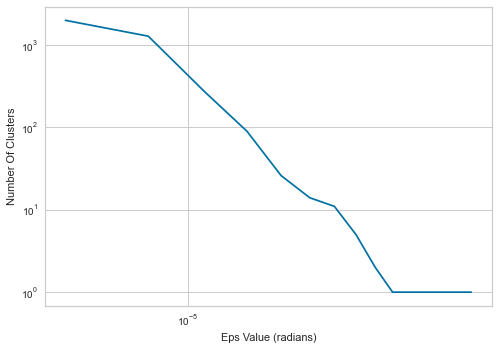

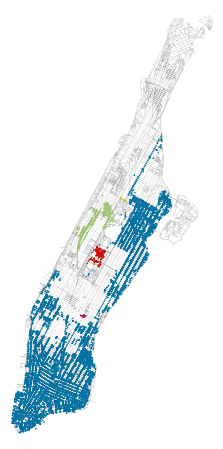

In [73]:
#dbscan calibration method

# now figuring optimal epsilon for city
cs = np.zeros(16)
for i in range(0, 16):
    db = DBSCAN(eps=np.linspace(0.000005, 0.000005 * 10, 16)[i], min_samples=5, algorithm='ball_tree', metric='haversine').fit(
        np.radians(X_G))
    cs[i] = len(np.unique(db.labels_))
    # print(0.000005*(i+1))

fig=plt.figure()
plt.loglog(np.linspace(0.000005, 0.000005 * 10, 16), cs)
plt.ylabel('Number Of Clusters')
plt.xlabel('Eps Value (radians)')
plt.savefig('dbscan_calib',dpi=600)

model = DBSCAN(eps=0.00003, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(X_G3))

dbc_labels = model.labels_
nc_dbc,ns_dbc=plot1(G, ids_G3, dbc_labels, 'dbscan_calib_G.png')


0
1
2
3
4
5
6
7
8
9


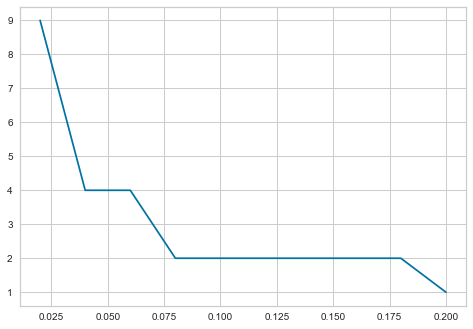

In [94]:

#hierarchical agglomerative clustering calibration method
n_l=np.zeros(10)
for i in range(0,10):
    
    model = AgglomerativeClustering(distance_threshold=np.linspace(0.02,.2,10)[i], n_clusters=None)
    model = model.fit(np.radians(X_G))
    distances = model.distances_
    n_l[i]=len(np.unique(model.labels_))
    print(i)
plt.plot(np.linspace(0.02,.2,10),n_l)




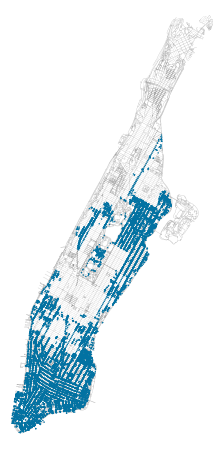

In [95]:
model = AgglomerativeClustering(distance_threshold=.2, n_clusters=None)
model = model.fit(np.radians(X_G3))
ag_labels = model.labels_
nc_ag,ns_ag=plot1(G, ids_G3, ag_labels, 'hierarch_calib_G.png')



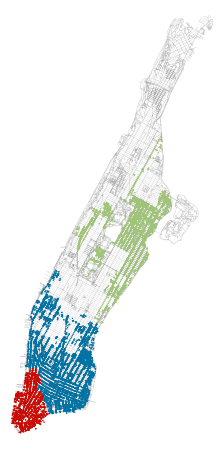

In [102]:
model = AgglomerativeClustering(n_clusters=3)
model = model.fit(np.radians(X_G3))
ag_3_labels = model.labels_
nc_ag_3,ns_ag_3=plot1(G, ids_G3, ag_3_labels, 'hierarch_calib_3.png')



In [106]:
corr_k3 = jaccard_score(labels, k3_labels,average='micro')
corr_ke = jaccard_score(labels, ke_labels,average='micro')
corr_dbe = jaccard_score(labels, dbe_labels,average='micro')
corr_dbc = jaccard_score(labels, dbc_labels,average='micro')
corr_ag = jaccard_score(labels, ag_labels,average='micro')
corr_ag_3 = jaccard_score(labels, ag_3_labels,average='micro')

In [107]:
print(corr_k3,corr_ke,corr_dbe,corr_dbc,corr_ag,corr_ag_3)

0.4512790921331025 0.1808194309681054 0.00023861919028554763 0.5184544173878044 0.5199226461464083 0.6557384244020189


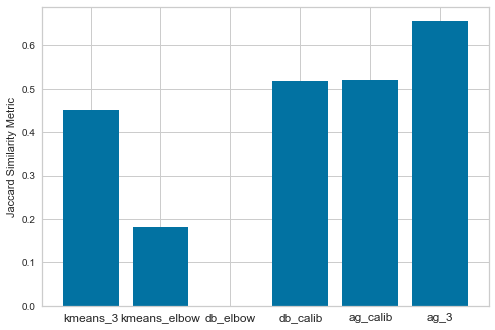

In [109]:
x = [1, 2, 3, 4, 5, 6]
labels=['kmeans_3','kmeans_elbow','db_elbow','db_calib','ag_calib', 'ag_3']
y = np.array([corr_k3,corr_ke,corr_dbe,corr_dbc,corr_ag,corr_ag_3])
plt.bar(x,y)
plt.xticks(x, labels,fontsize=12)
plt.ylabel('Jaccard Similarity Metric')

plt.savefig('jacc.png',dpi=600)